## First part: Pre-Processing The Data

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import random as random
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

def loadSchoolData():
  # reading in all the CSVs
  absentee = pd.read_csv('sample_data/absenteeism_cleaned.csv')
  char = pd.read_csv('sample_data/public_school_char.csv')
  diplomas_completion = pd.read_csv('sample_data/dip_comp.csv')
  on_time_grad_rate = pd.read_csv('sample_data/on-time_grad.csv')
  postsecondary = pd.read_csv('sample_data/postsecondary.csv')
  teach = pd.read_csv('sample_data/teacher_quality_filtered.csv')
  # cleaning the data (selecting the features we want to keep, reformatting, renaming)
  columns_to_drop_absentee =['Indicator', 'Division', 'Year', 'Description']
  char = char.loc[:, ['SCH_NAME', 'TITLEI', 'STUTERATIO','LATCOD', 'LONCOD']]
  char['TITLEI'] = char['TITLEI'].apply(lambda x: x.split('-')[0])
  char.rename(columns={'SCH_NAME': 'School', 'TITLEI' : 'TitleI', 'STUTERATIO' : 'Student Teacher Ratio', 'LATCOD' : 'Latitude', 'LONCOD' : 'Longitude'}, inplace=True)
  diplomas_completion = diplomas_completion.loc[:, ['School', 'Dropout Rate']]
  on_time_grad_rate = on_time_grad_rate.loc[:, ['School', 'Virginia On-Time Graduation Rate']]
  postsecondary = postsecondary.loc[:, ['School', 'Percent']]
  postsecondary.rename(columns={'Percent': 'Percent of Students enrolled in higher education within 16 months of graduation'}, inplace=True)
  absentee = absentee.drop(columns=columns_to_drop_absentee)
  columns_to_drop_teach= ['Year', 'Level', 'Division', 'Title1 Code']
  teach = teach.drop(columns=columns_to_drop_teach)
  # merging all the data together
  merged_data = pd.merge(absentee, teach, on='School')
  merged_data['School'] = merged_data['School'].str.upper()
  char['School'] = char['School'].str.upper()
  merged_data = pd.merge(merged_data, char, on='School')
  diplomas_completion['School'] = diplomas_completion['School'].str.upper()
  merged_data = pd.merge(merged_data, diplomas_completion, on='School')
  on_time_grad_rate['School'] = on_time_grad_rate['School'].str.upper()
  merged_data = pd.merge(merged_data, on_time_grad_rate, on='School')
  postsecondary['School'] = postsecondary['School'].str.upper()
  merged_data = pd.merge(merged_data, postsecondary, on='School')
  merged_data = merged_data.drop_duplicates(subset=['School'])
  return merged_data

school = loadSchoolData()
print(school.shape)
school = school.drop("School", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

school.to_csv (r'sample_data\school.csv', index=None)
school_num = school.drop(["Poverty Level"], axis=1)
num_attribs = list(school_num)
cat_attribs = ["Poverty Level"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train = full_pipeline.fit_transform(school)

school.to_csv (r'sample_data\school.csv', index=None)

(259, 15)


## Second part: Clustering Schools using K-Means

In [4]:
from sklearn.cluster import KMeans

def calculateStandardDeviation(X_train, kMeans, k):
  standard_deviations = []
  for cluster in range(k):
    points = [X_train[i] for i in range(len(X_train)) if kMeans.labels_[i] == cluster]
    deviation = np.std(points, axis=0)
    standard_deviations.append(deviation)
  return standard_deviations

squared_errors = []
for i in range(10):
  k = (i + 1)
  kMeans = KMeans(n_clusters=k, n_init=10);
  y_pred = kMeans.fit(X_train);
  cluster_labels = kMeans.labels_
  squareError = kMeans.inertia_;
  squared_errors.append(squareError);

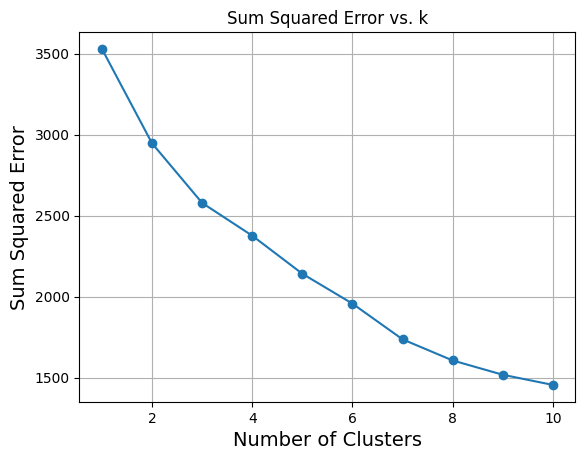

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(1, k + 1), squared_errors, marker='o', linestyle='-')
plt.ylabel("Sum Squared Error", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=14)
plt.title("Sum Squared Error vs. k")
plt.grid(True)
plt.show()

In [6]:
k = 3
kMeans = KMeans(n_clusters=k, random_state=(42));
y_pred = kMeans.fit(X_train);
squareError = kMeans.inertia_;
squared_errors.append(squareError);
print("Sum Squared Error for", 3, "clusters: ", squareError)
print("Cluster means:", kMeans.cluster_centers_)
print("Within cluster standard deviation: ", calculateStandardDeviation(X_train, kMeans, k))

Sum Squared Error for 3 clusters:  2579.182787830642
Cluster means: [[ 0.69743162  0.02005993  1.10633373  0.82249349  0.903859    1.0770948
  -0.13502732  0.26966413  0.07171348  0.34293892  1.06271839 -1.18265484
  -0.70958399  0.41304348  0.04347826  0.54347826]
 [ 0.38119066  0.77786273 -0.42925417 -0.2354135  -0.30879282 -0.25777905
   0.1539981   0.48005983  0.40065413  0.5335571  -0.31391803  0.38790557
   0.69147346  0.0625      0.57142857  0.36607143]
 [-0.7403486  -0.87171666 -0.02787015 -0.11354841 -0.06923483 -0.20470403
  -0.10927258 -0.6551609  -0.47695132 -0.74785728 -0.13590324  0.10848217
  -0.44360559  0.30693069  0.06930693  0.62376238]]
Within cluster standard deviation:  [array([1.22228474, 0.8676107 , 1.18345938, 1.31796464, 1.09936638,
       1.73831488, 1.35564939, 0.94022238, 0.96396572, 0.6445856 ,
       1.69590252, 1.49464709, 0.78295662, 0.49238051, 0.20393112,
       0.49810605]), array([8.43353479e-01, 7.34635710e-01, 6.90496558e-01, 6.75826090e-01,
     

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualizing the Clusters


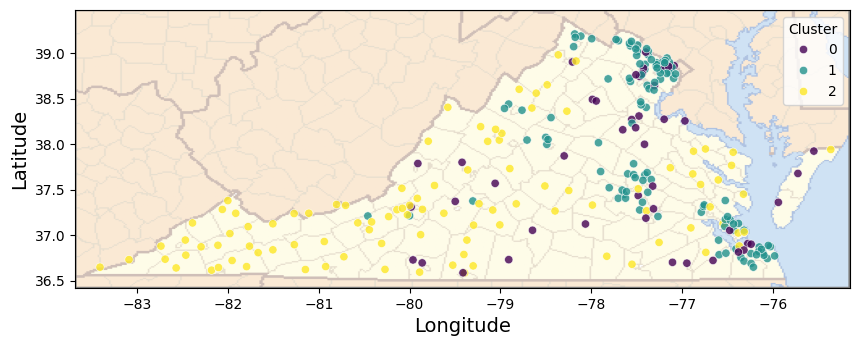

In [7]:
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_ROOT_DIR = "."
virginia=mpimg.imread(PROJECT_ROOT_DIR + '/virginia_map.png')
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=school,
    x="Longitude",
    y="Latitude",
    hue=kMeans.labels_,
    palette="viridis",
    alpha=0.8
)

plt.imshow(virginia, extent=[-83.682861328125, -75.15197753906251, 36.42127365634205, 39.47966555205487], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.legend(title="Cluster")
plt.show()

## DBSCAN

(259, 16)


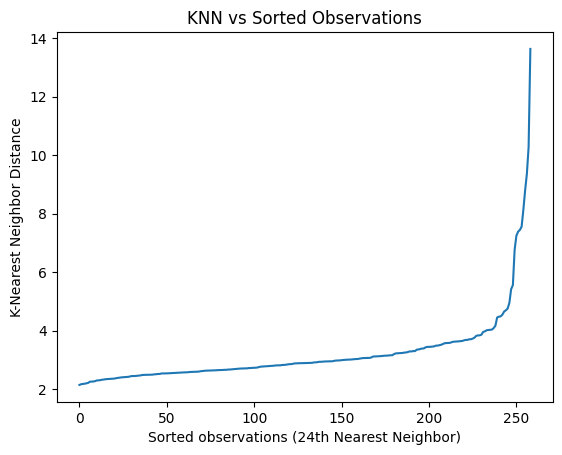

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{0}


Counter({0: 259})

In [8]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter

print(X_train.shape)

number_of_features = 12;
minimum_samples = 2 * number_of_features;

neighbors = NearestNeighbors(n_neighbors=minimum_samples+1).fit(X_train)
neighbor_distance, neighbor_ind = neighbors.kneighbors(X_train)
sort_neighbor_distance = np.sort(neighbor_distance, axis = 0)

k_distance = sort_neighbor_distance[:, minimum_samples]
plt.plot(k_distance)
plt.title("KNN vs Sorted Observations")
plt.ylabel("K-Nearest Neighbor Distance")
plt.xlabel("Sorted observations (24th Nearest Neighbor)")
plt.show()

clusters = DBSCAN(eps=250, min_samples=minimum_samples).fit(X_train)

print(clusters.labels_)

print(set(clusters.labels_))

Counter(clusters.labels_)

## Gaussian Mixture Clustering


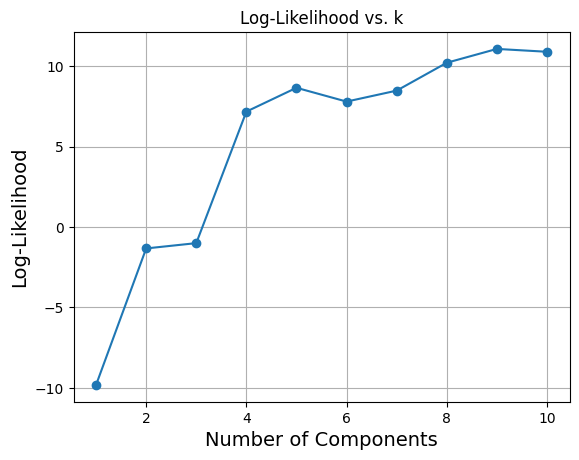

[3 3 3 1 4 0 4 4 4 4 2 1 1 4 4 4 4 4 0 3 3 4 3 0 4 2 4 3 3 4 4 4 4 4 4 2 4
 4 4 4 0 0 0 4 4 0 0 4 4 4 0 0 4 1 2 4 4 4 4 4 3 2 4 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 4 4 4 4 1 4 1 4 4 4 4 4 0 4 4 2 4 0 4 4 0 0 0
 0 0 4 0 0 4 4 4 4 4 4 2 4 0 4 1 3 3 3 4 3 1 1 1 1 1 2 1 1 1 1 1 1 4 4 1 4
 4 4 3 4 0 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 2 4 4 4 4 0 4 4 4 0 4 4 1 1 1 1 1
 1 1 4 1 4 4 2 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 3 2 4 4 4 4 4 4 1 4 4 1 1 1 4
 4 4 4 3 4 4 4 4 4 0 0 0 4 4 4 0 0 4 4 4 4 4 4 3 0 4 0 1 3 3 4 0 4 4 0 0 4]


In [9]:
# Import necessary libraries
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

scores = []
for i in range(10):
    k = (i + 1)
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X_train)
    log_likelihood = gmm.score(X_train)
    scores.append(log_likelihood)

plt.plot(range(1, 11), scores, marker='o', linestyle='-')
plt.ylabel("Log-Likelihood", fontsize=14)
plt.xlabel("Number of Components", fontsize=14)
plt.title("Log-Likelihood vs. k")
plt.grid(True)
plt.show()

lowest_bic = np.infty
best_n_components = 0

for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_train)
    bic = gmm.bic(X_train)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n_components = n_components

best_gmm = GaussianMixture(n_components=best_n_components)
best_gmm.fit(X_train)
labels = best_gmm.predict(X_train)
print(labels)


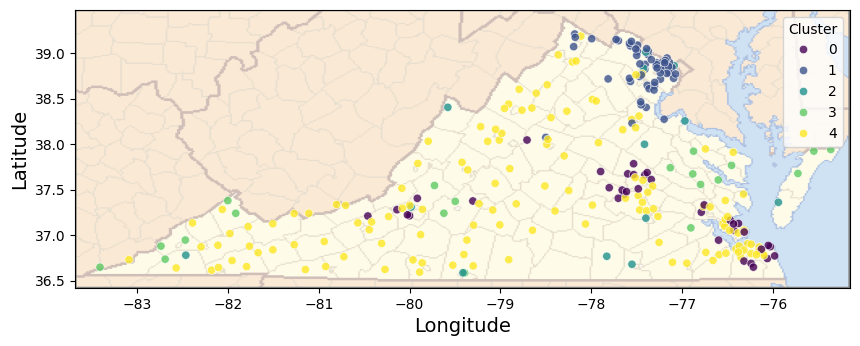

In [10]:
PROJECT_ROOT_DIR = "."
virginia=mpimg.imread(PROJECT_ROOT_DIR + '/virginia_map.png')
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=school,
    x="Longitude",
    y="Latitude",
    hue=labels,
    palette="viridis",
    alpha=0.8
)

plt.imshow(virginia, extent=[-83.682861328125, -75.15197753906251, 36.42127365634205, 39.47966555205487], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.legend(title="Cluster")
plt.show()